In [14]:
import math
import sys
sys.path.append('..')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from matplotlib import gridspec
from matplotlib.image import imread
import numpy as np
from scipy import stats

import config
import data
from parser import parse_eyedata

IMG_DIR = '../../motion_distributions/data/train'

# Importing and processing data

## Importing data

In [3]:
# Grabbing the trial data
trials = parse_eyedata('../data/pilots/test/raw.asc')

Trial start and end points are unmatched. Removing last start.


## Processing data

In [15]:
all_gaze_df = pd.DataFrame()
all_saccade_df = pd.DataFrame()
all_fixation_df = pd.DataFrame()
for idx, t in enumerate(trials):
    # Trial information
    t_idx = t['idx']
    scene_name = t['scene_name']
    # Get gaze data
    gaze_data = t['gaze']
    gaze_df = pd.DataFrame(gaze_data, columns=data.Gaze._fields)
    gaze_df['scene_name'] = scene_name
    all_gaze_df = pd.concat([all_gaze_df, gaze_df])
    # Get saccade data
    saccade_data = t['saccades']
    saccade_df = pd.DataFrame(saccade_data, columns=data.Saccade._fields)
    saccade_df['scene_name'] = scene_name
    all_saccade_df = pd.concat([all_saccade_df, saccade_df])
    # Get fixation data
    fixation_data = t['fixations']
    fixation_df = pd.DataFrame(fixation_data, columns=data.Fixation._fields)
    fixation_df['scene_name'] = scene_name
    all_fixation_df = pd.concat([all_fixation_df, fixation_df])

In [5]:
all_gaze_df

,time,x,y,fixation,saccade,blink,event,scene_name
0,314.113,965.1,558.0,False,False,False,None,med_nocol_nosp_2
1,314.114,964.4,557.9,False,False,False,None,med_nocol_nosp_2
2,314.115,964.3,558.1,False,False,False,None,med_nocol_nosp_2
3,314.116,964.1,558.0,False,False,False,None,med_nocol_nosp_2
4,314.117,964.1,558.2,False,False,False,None,med_nocol_nosp_2
...,...,...,...,...,...,...,...,...
1611,371.209,953.8,976.1,True,False,False,fixation,low_nocol_nosp_2
1612,371.210,953.3,976.6,True,False,False,fixation,low_nocol_nosp_2
1613,371.211,952.9,976.8,True,False,False,fixation,low_nocol_nosp_2
1614,371.212,953.0,977.1,True,False,False,fixation,low_nocol_nosp_2


# Plotting data

## Plotting functions

In [6]:
def plot(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    # Create a figure with gridspec
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0)
    all_densities = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name]
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            # Calculate padding
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            # Display image
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')  # Light gray background if image not found
        # Calculate KDE
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        # Plot scatter with color intensity based on KDE
        scatter = ax.scatter(x, y, c=z, cmap='Blues', alpha=0.2)
        all_densities.extend(z)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    # Remove any unused subplots
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    # Add a single colorbar on the right side of the figure
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin = min(all_densities)
    vmax = max(all_densities)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle("Eye Gaze Data Across Scenes", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_opacity_gradient(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0)
    all_densities = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name]
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        # Normalize time values to use as alpha
        time = scene_df['time'] - scene_df['time'].min()
        time_norm = (time - time.min()) / (time.max() - time.min())
        scatter = ax.scatter(x, y, c=z, cmap='Blues', alpha=time_norm, s=10)
        all_densities.extend(z)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle("Eye Gaze Data Across Scenes (Opacity = Time)", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_directional_arrows(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0)
    all_densities = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name].sort_values('time')
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        scatter = ax.scatter(x, y, c=z, cmap='Blues', alpha=0.5, s=10)
        all_densities.extend(z)
        # Add directional arrows
        interval = len(x) // 10
        for j in range(0,len(x) - 1,interval):
            dx = x.iloc[j+1] - x.iloc[j]
            dy = y.iloc[j+1] - y.iloc[j]
            ax.arrow(x.iloc[j], y.iloc[j], dx, dy, 
                     head_width=60, head_length=60, fc='r', ec='r', alpha=0.6)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle("Eye Gaze Data Across Scenes (with Directional Arrows)", fontsize=16, y=0.92)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_line_traces(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png'):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+3, grid_size, height_ratios=[1]*grid_size + [0.05, 0.1, 0.05], wspace=0.05, hspace=0.1)
    
    all_densities = []
    all_times = []
    
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name].sort_values('time')
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        
        x = scene_df['x'].clip(0, 1920)
        y = scene_df['y'].clip(0, 1080)
        times = scene_df['time']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        norm = plt.Normalize(times.min(), times.max())
        lc = LineCollection(segments, cmap='cool', norm=norm)
        lc.set_array(times[:-1])
        line = ax.add_collection(lc)
        
        scatter = ax.scatter(x, y, c=z, cmap='Blues', alpha=0.5, s=10)
        all_densities.extend(z)
        all_times.extend(times)
        
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add clipping
        clip_rect = Rectangle((0, 0), 1920, 1080, fill=False)
        ax.add_patch(clip_rect)
        for artist in ax.get_children():
            artist.set_clip_path(clip_rect)
    
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    
    # Gaze density colorbar
    cbar_ax1 = fig.add_subplot(gs[-3, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm1.set_array([])
    cbar1 = plt.colorbar(sm1, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Gaze Density')
    
    # Time progression colorbar
    cbar_ax2 = fig.add_subplot(gs[-1, :])
    time_min, time_max = min(all_times), max(all_times)
    sm2 = plt.cm.ScalarMappable(cmap='cool', norm=plt.Normalize(time_min, time_max))
    sm2.set_array([])
    cbar2 = plt.colorbar(sm2, cax=cbar_ax2, orientation='horizontal')
    cbar2.set_label('Time Progression')
    
    # Format time labels
    def format_time(t, pos):
        return f"{(t - time_min) / 1e9:.1f}s"  # Assuming timestamps are in nanoseconds
    cbar2.ax.xaxis.set_major_formatter(plt.FuncFormatter(format_time))
    
    plt.suptitle("Eye Gaze Data Across Scenes (with Time Traces)", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

In [10]:
def plot_animated(df, image_path_template=f'{IMG_DIR}'+'/{scene_name}_0.png', interval=1, save_path=True):
    scene_names = df['scene_name'].unique()
    num_scenes = len(scene_names)
    grid_size = math.ceil(math.sqrt(num_scenes))
    fig = plt.figure(figsize=(5*grid_size, 3.5*grid_size))
    gs = gridspec.GridSpec(grid_size+1, grid_size, height_ratios=[1]*grid_size + [0.05], wspace=0.05, hspace=0)
    all_densities = []
    scatter_plots = []
    for i, scene_name in enumerate(scene_names):
        scene_df = df[df['scene_name'] == scene_name].sort_values('time')
        ax = fig.add_subplot(gs[i // grid_size, i % grid_size])
        try:
            img_path = image_path_template.format(scene_name=scene_name)
            img = imread(img_path)
            img_height, img_width = img.shape[:2]
            pad_left = (1920 - img_width) // 2
            pad_top = (1080 - img_height) // 2
            ax.imshow(img, extent=[pad_left, pad_left+img_width, 1080-pad_top, 1080-pad_top-img_height])
        except FileNotFoundError:
            print(f"Image not found for scene: {img_path}")
            ax.set_facecolor('#f0f0f0')
        x = scene_df['x']
        y = scene_df['y']
        xy = np.vstack([x, y])
        z = stats.gaussian_kde(xy)(xy)
        scatter = ax.scatter([], [], c='blue', alpha=0.5, s=10)
        scatter_plots.append((scatter, x, y, z))
        all_densities.extend(z)
        ax.set_title(f"Scene: {scene_name}", fontsize=15)
        ax.set_ylim(1080, 0)
        ax.set_xlim(0, 1920)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
    for j in range(i+1, grid_size * grid_size):
        fig.add_subplot(gs[j // grid_size, j % grid_size]).remove()
    cbar_ax = fig.add_subplot(gs[-1, :])
    vmin, vmax = min(all_densities), max(all_densities)
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, cax=cbar_ax, label='Gaze Density', orientation='horizontal')
    plt.suptitle("Eye Gaze Data Across Scenes (Animated)", fontsize=16, y=0.92)
    def animate(frame):
        for scatter, x, y, z in scatter_plots:
            scatter.set_offsets(np.c_[x[:frame], y[:frame]])
            scatter.set_array(z[:frame])
        return [scatter for scatter, _, _, _ in scatter_plots]
    anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=interval, blit=True, repeat=False)
    if save_path:
        anim.save('test2.mp4', writer='ffmpeg', fps=60)
    else:
        plt.show()
    return anim

## Generating plots

In [11]:
# plot(all_gaze_df)

In [12]:
# plot_opacity_gradient(all_gaze_df);

MovieWriter ffmpeg unavailable; using Pillow instead.


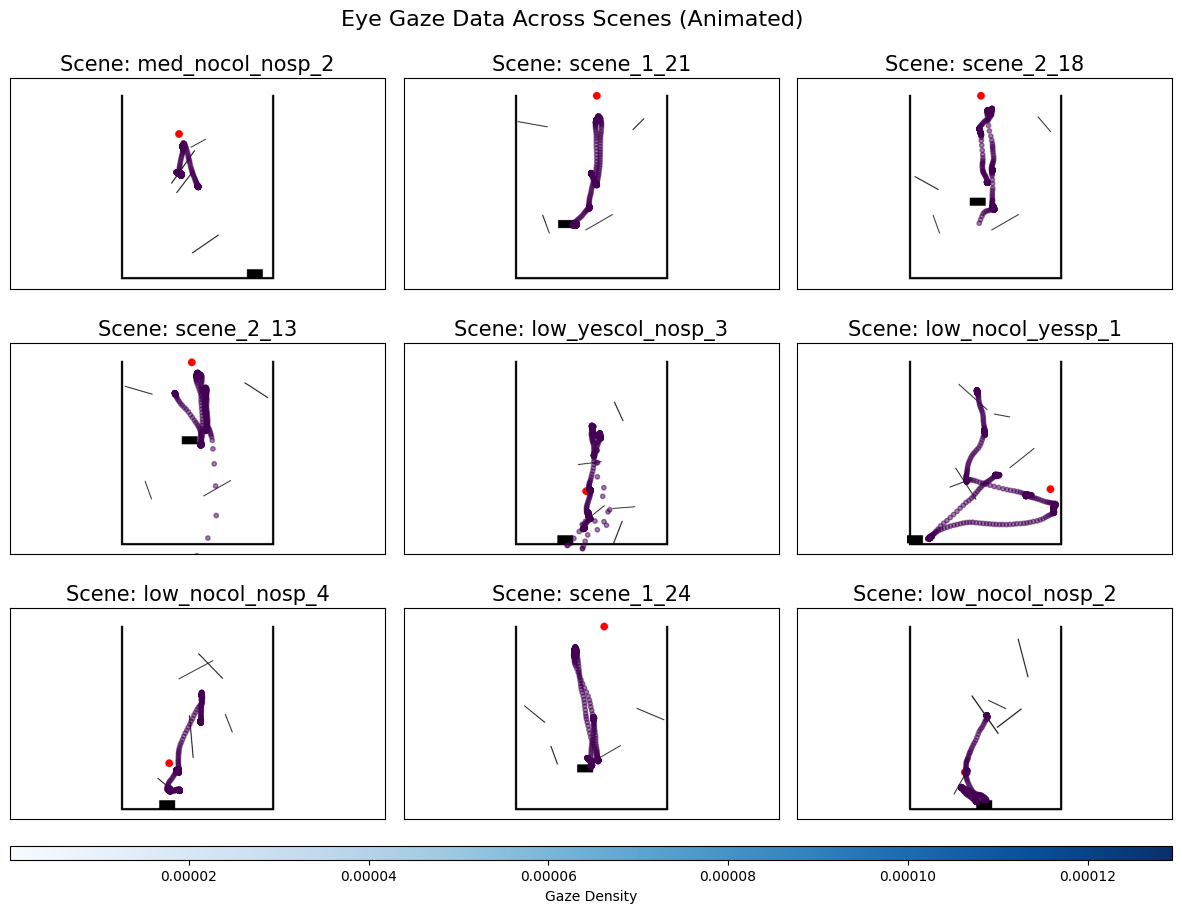

In [13]:
plot_animated(all_gaze_df)

In [209]:
# plot_directional_arrows(all_gaze_df)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_15920/269517357.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


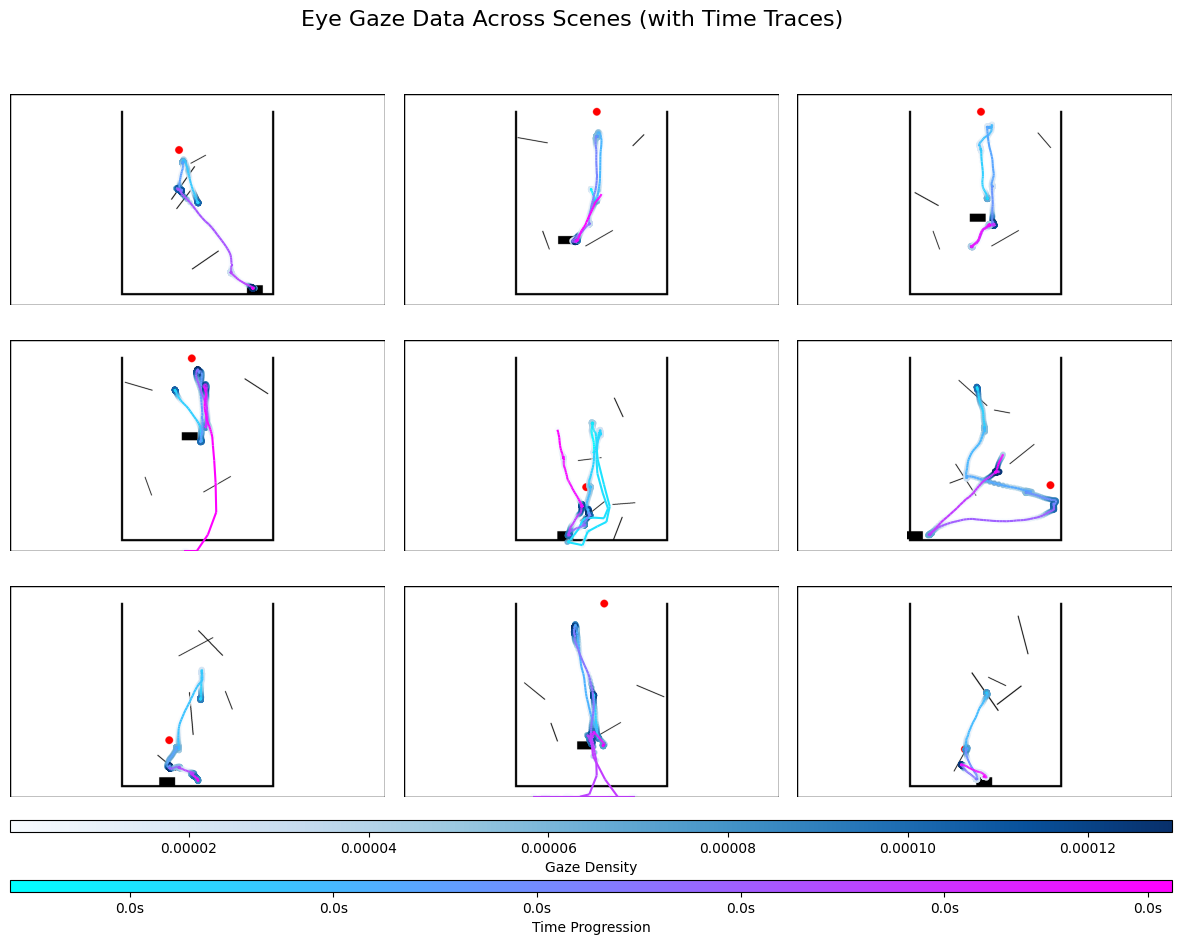

In [223]:
plot_line_traces(all_gaze_df)

In [204]:
all_gaze_df.y.describe()

count    18701.000000
mean       668.977814
std        246.665029
min        149.300000
25%        496.500000
50%        684.800000
75%        889.100000
max       1317.300000
Name: y, dtype: float64